# Projet : Équation de Black et Scholes avec contrainte Gamma
> Matthieu OLEKHNOVITCH - *Nov-Dec 2024*

Ce projet a pour but de modéliser la valeur d'une option européenne de type put dans le cadre d'une contrainte sur le gamma. En effet, on reprend le modèle de Black et Scholes vu en cours, mais on ajoute une constante $\Gamma>0$ qui contraint de tel sorte que :
$$s\frac{\partial^2 v}{\partial x^2} \le \Gamma$$

## 0 - Paramètres globaux pour applications numériques

On utilise les paramètres donnés dans l'énoncé pour les applications numériques. Ils sont définis dans la cellule suivante.
Seul T a été modifié pour des raisons de visualisation (T=1 au lieu de T=0.1).

In [40]:
K = 100  # Prix d'exercice de l'option
T = 1  # Échéance de l'option en années
r = 0.1  # Taux d'intérêt sans risque
sigma = 0.1  # Volatilité du sous-jacent
Gamma = 1  # Contrainte sur la dérivée seconde
N = 150  # Nombre de pas dans le maillage en espace 
J = 250  # Nombre de pas dans le maillage en temps
bar_x = 300.0  # Bord du domaine coupé

We will be only using numpy and matplotlib for this project.

In [41]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Calcul de ĝ pour le put

On commence par définir les payout pour les deux cas de put de l'énoncé :

In [42]:
# Cas 1 ( g(s) = max(K - s, 0) )
def g(x, K):
    return np.maximum(K - x, 0)

# Cas 2 ( g(s) = max(K - 2|K - s|, 0) )
def g2(x, K):
    return np.maximum(K - 2 * np.abs(K - x), 0)

On vérifie que les fonctions g et g2 sont correctes en les affichant :

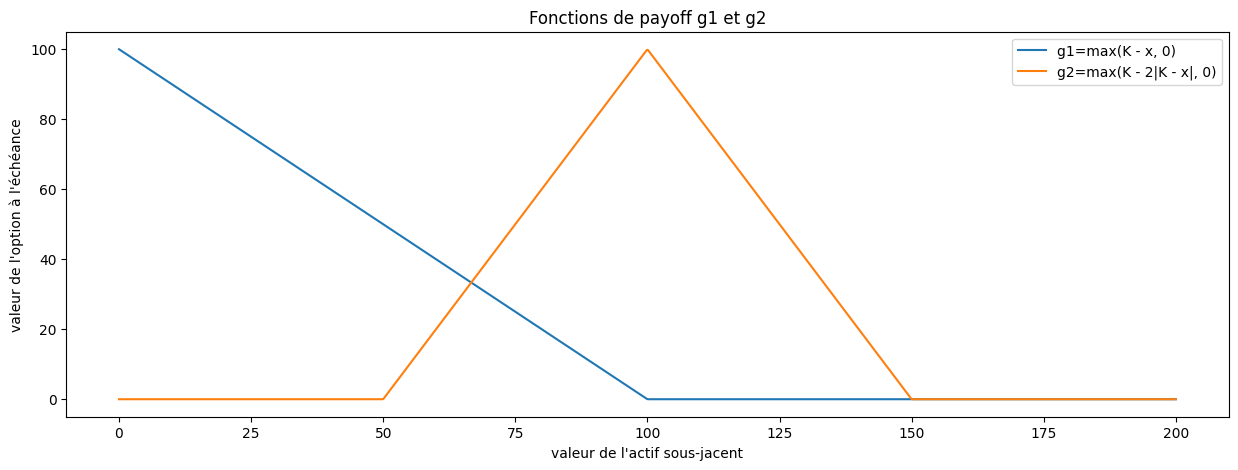

In [43]:
x = np.linspace(0, 2 * K, 1000)
plt.figure(figsize=(15, 5))
plt.plot(x, g(x, K), label="g1=max(K - x, 0)")
plt.plot(x, g2(x, K), label="g2=max(K - 2|K - x|, 0)")
plt.title("Fonctions de payoff g1 et g2")
plt.xlabel("valeur de l'actif sous-jacent")
plt.ylabel("valeur de l'option à l'échéance")
plt.legend()
plt.show()


On va utiliser la méthode de Newton pour calculer la valeur de $ĝ$ pour le put mais d'abord, il est nécessaire de pouvoir estimer facilement la dérivée seconde de $v$ par rapport à $x$. On définit donc la fonction qui permet de la calculer en approximant : 
> $$\frac{\partial^2 v}{\partial x^2} \approx \frac{v(x+h) - 2v(x) + v(x-h)}{h^2}$$

In [44]:
def compute_gamma(u, x, h):
    N = len(x)
    gamma = np.zeros(N)
    gamma[1:-1] = (u[:-2] - 2 * u[1:-1] + u[2:]) / (h ** 2)
    gamma[0] = gamma[1]
    gamma[-1] = gamma[-2]
    return gamma

Et on définit ensuite la fonction ```project_gamma_constraint``` qui projette la solution pour respecter la contrainte sur le gamma


In [45]:
def project_gamma_constraint(u, x, h, Gamma):
    gamma = compute_gamma(u, x, h)
    for i in range(1, len(x) - 1):
        if x[i] * gamma[i] > Gamma:
            delta = (x[i] * gamma[i] - Gamma) * (h * h)
            u[i] = (u[i - 1] + u[i + 1]) / 2 - delta / (2 * x[i])
    return u

## 2. Programmation des différences finies

On va maintenant utiliser la méthode de Cranck-Nicholson pour résoudre le problème. Il est nécessaire de définir la matrice $A$ qui va représenter le système linéaire à résoudre. On définit donc la fonction ```mat_A``` qui permet de calculer cette matrice.

In [46]:
def mat_A(sigma, r, x):
    N = x.size
    h = x[1] - x[0]
    A1 = (
        -1
        / (2.0 * h * h)
        * np.diag(np.power(sigma * x, 2)).dot(
            np.eye(N, k=-1) - 2.0 * np.eye(N) + np.eye(N, k=1)
        )
    )
    A2 = -1 / (2 * h) * np.diag(r * x).dot(-np.eye(N, k=-1) + np.eye(N, k=1))
    A3 = r * np.eye(N)
    return A1 + A2 + A3

Et on a plus qu'à construire la fonction ```solve_cn``` qui va résoudre le problème en utilisant la méthode de Cranck-Nicholson comme vu en td, mais en incorporant la contrainte sur le gamma. On ajoute un argument ```with_constraint``` qui permet de choisir si on veut ou non respecter la contrainte sur le gamma et qui nous permettra de comparer les résultats.

In [47]:
def solve_cn(payoff_func, with_constraint=True, Gamma=Gamma):
    x = np.linspace(0, bar_x, N, endpoint=False)
    h = x[1] - x[0]
    k = T / J

    A = mat_A(sigma, r, x)
    B1 = np.eye(N) + k / 2.0 * A
    B2 = np.eye(N) - k / 2.0 * A

    U0 = payoff_func(x, K)
    Uj = U0.copy()

    solutions = []

    for j in range(J):
        Uj_temp = np.linalg.solve(B1, B2.dot(Uj))
        if with_constraint:
            Uj = project_gamma_constraint(Uj_temp, x, h, Gamma)
        else:
            Uj = Uj_temp

        if (j + 1) % 10 == 0:
            solutions.append(Uj.copy())

    return x, U0, Uj, solutions

## 3. Résultats et comparaison avec le cas sans contrainte

***
Visualisations
***

### CAS 1 : $g(s) = \max(K-s,0)$

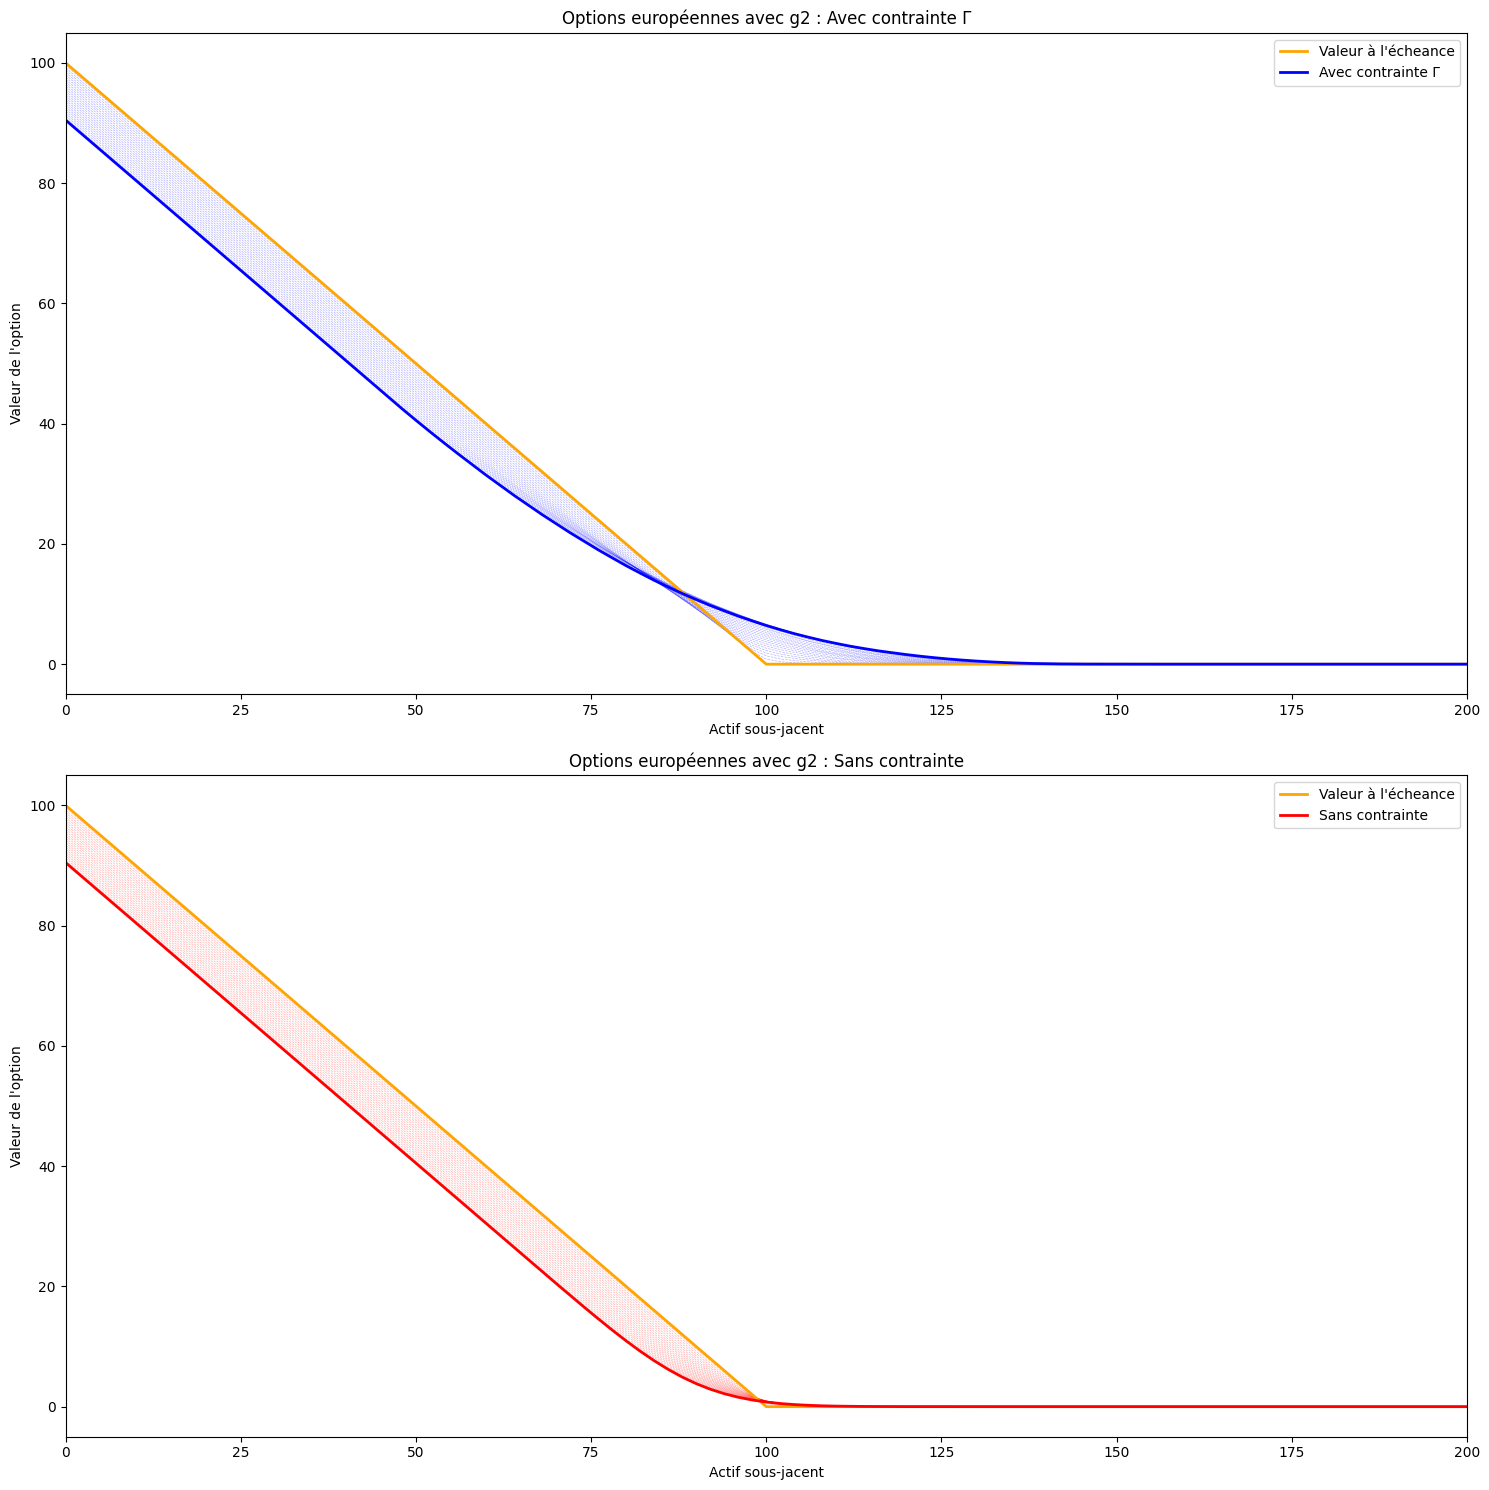

In [48]:
fig, axs = plt.subplots(2, 1, figsize=(15, 15))

x, U0_g, Uj_g_constraint, solutions_g_constraint = solve_cn(g, True)
_, _, Uj_g_no_constraint, solutions_g_no_constraint = solve_cn(g, False)

for sol in solutions_g_constraint:
    axs[0].plot(x, sol, color="blue", linestyle="dashed", linewidth=0.5, alpha=0.3)
for sol in solutions_g_no_constraint:
    axs[1].plot(x, sol, color="red", linestyle="dashed", linewidth=0.5, alpha=0.3)

axs[0].plot(
    x,
    U0_g,
    color="orange",
    linestyle="solid",
    linewidth=2,
    label="Valeur à l'écheance",
)
axs[0].plot(
    x,
    Uj_g_constraint,
    color="blue",
    linestyle="solid",
    linewidth=2,
    label="Avec contrainte Γ",
)
axs[1].plot(
    x,
    U0_g,
    color="orange",
    linestyle="solid",
    linewidth=2,
    label="Valeur à l'écheance",
)
axs[1].plot(
    x,
    Uj_g_no_constraint,
    color="red",
    linestyle="solid",
    linewidth=2,
    label="Sans contrainte",
)

# Set labels and titles
axs[0].set_xlabel("Actif sous-jacent")
axs[0].set_ylabel("Valeur de l'option")
axs[0].set_xlim((0.0, 200))
axs[0].set_title("Options européennes avec g2 : Avec contrainte Γ")
axs[0].legend()

axs[1].set_xlabel("Actif sous-jacent")
axs[1].set_ylabel("Valeur de l'option")
axs[1].set_xlim((0.0, 200))
axs[1].set_title("Options européennes avec g2 : Sans contrainte")
axs[1].legend()

plt.tight_layout()
plt.show()

Cela est très cohérent avec l'évolution constatée dans le cadre d'une option **américaine** comme décrite dans le papier de recherche ```SOME CONVERGENCE RESULTS FOR HOWARD’S ALGORITHM```(Olivier BOKANOWSKI , Stefania MAROSO , & Hasnaa ZIDANI) qui montre cette adaptation de la courbure de la fonction de paiement en fonction de la contrainte sur le gamma. Bien évidemment le prix initial de l'option est inférieur au payoff dans le cas des options européennes comme on l'a vu en cours alors que dans le cas des options américaines, le prix initial est égal au payoff lorsque $s\to 0$.

![put1](Howard.png)

On limite l'inflexion possible de la courbe de valeur de l'option en fonxtion de la valeur du sous-jacent et on 'lisse' donc le résultat.

### CAS 2 : $g(s) = \max(K-2|K-s|,0)$

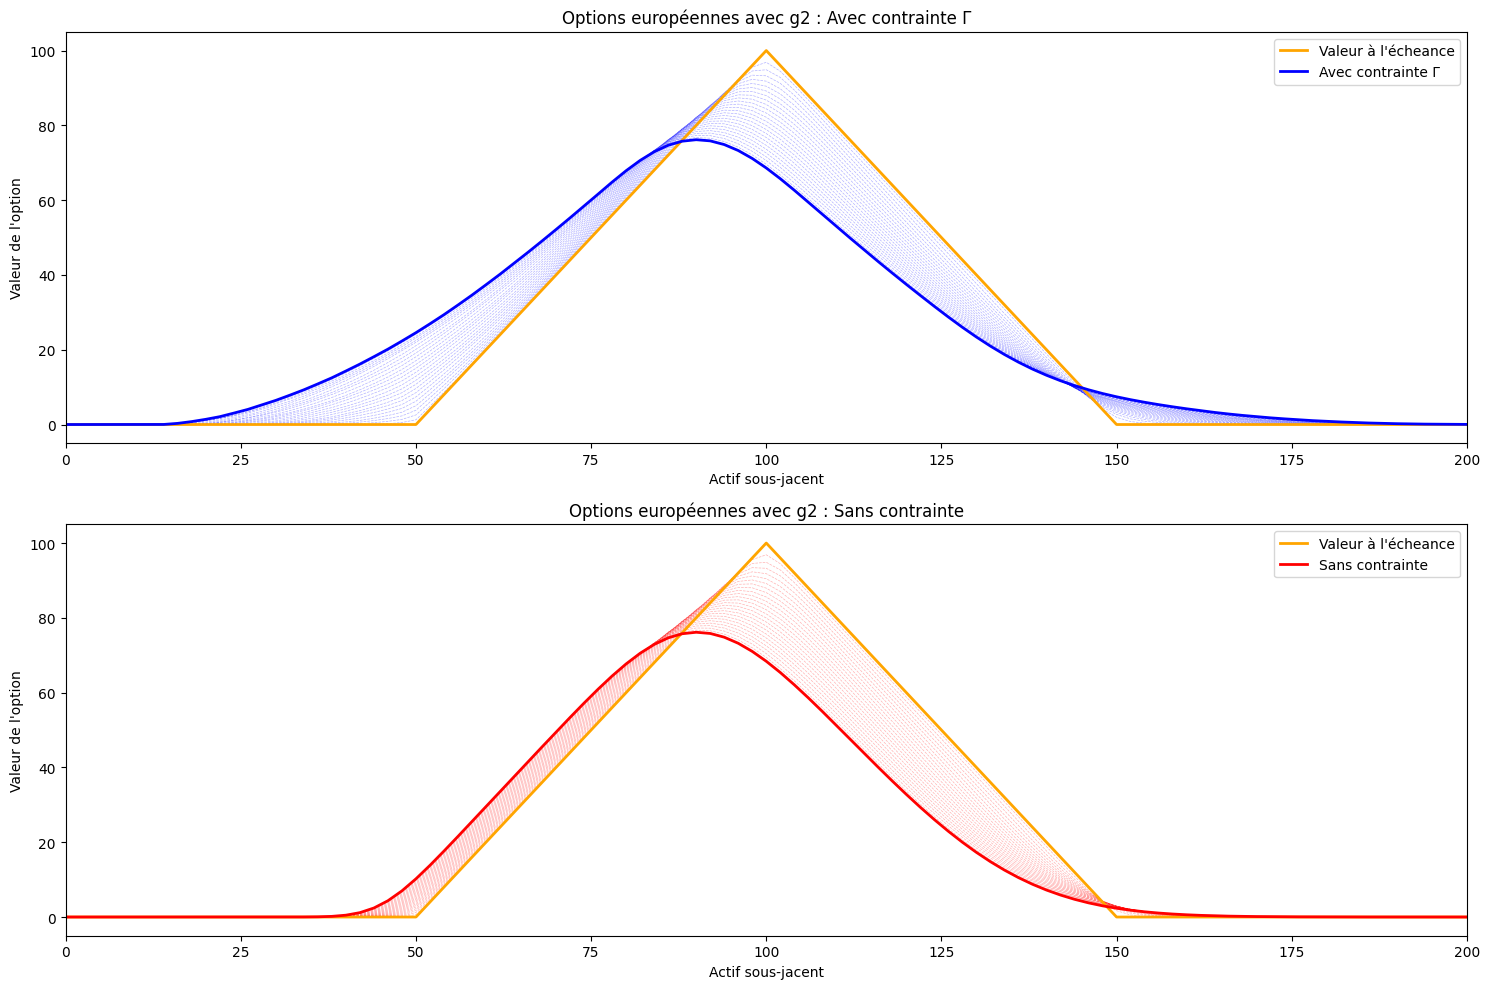

In [49]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

x, U0_g2, Uj_g2_constraint, solutions_g2_constraint = solve_cn(g2, True)
_, _, Uj_g2_no_constraint, solutions_g2_no_constraint = solve_cn(g2, False)

for sol in solutions_g2_constraint:
    axs[0].plot(x, sol, color="blue", linestyle="dashed", linewidth=0.5, alpha=0.3)
for sol in solutions_g2_no_constraint:
    axs[1].plot(x, sol, color="red", linestyle="dashed", linewidth=0.5, alpha=0.3)

axs[0].plot(
    x,
    U0_g2,
    color="orange",
    linestyle="solid",
    linewidth=2,
    label="Valeur à l'écheance",
)
axs[0].plot(
    x,
    Uj_g2_constraint,
    color="blue",
    linestyle="solid",
    linewidth=2,
    label="Avec contrainte Γ",
)
axs[1].plot(
    x,
    U0_g2,
    color="orange",
    linestyle="solid",
    linewidth=2,
    label="Valeur à l'écheance",
)
axs[1].plot(
    x,
    Uj_g2_no_constraint,
    color="red",
    linestyle="solid",
    linewidth=2,
    label="Sans contrainte",
)

axs[0].set_xlabel("Actif sous-jacent")
axs[0].set_ylabel("Valeur de l'option")
axs[0].set_xlim((0.0, 200))
axs[0].set_title("Options européennes avec g2 : Avec contrainte Γ")
axs[0].legend()

axs[1].set_xlabel("Actif sous-jacent")
axs[1].set_ylabel("Valeur de l'option")
axs[1].set_xlim((0.0, 200))
axs[1].set_title("Options européennes avec g2 : Sans contrainte")
axs[1].legend()

plt.tight_layout()
plt.show()

### Comparaison pour différents $\Gamma$
***

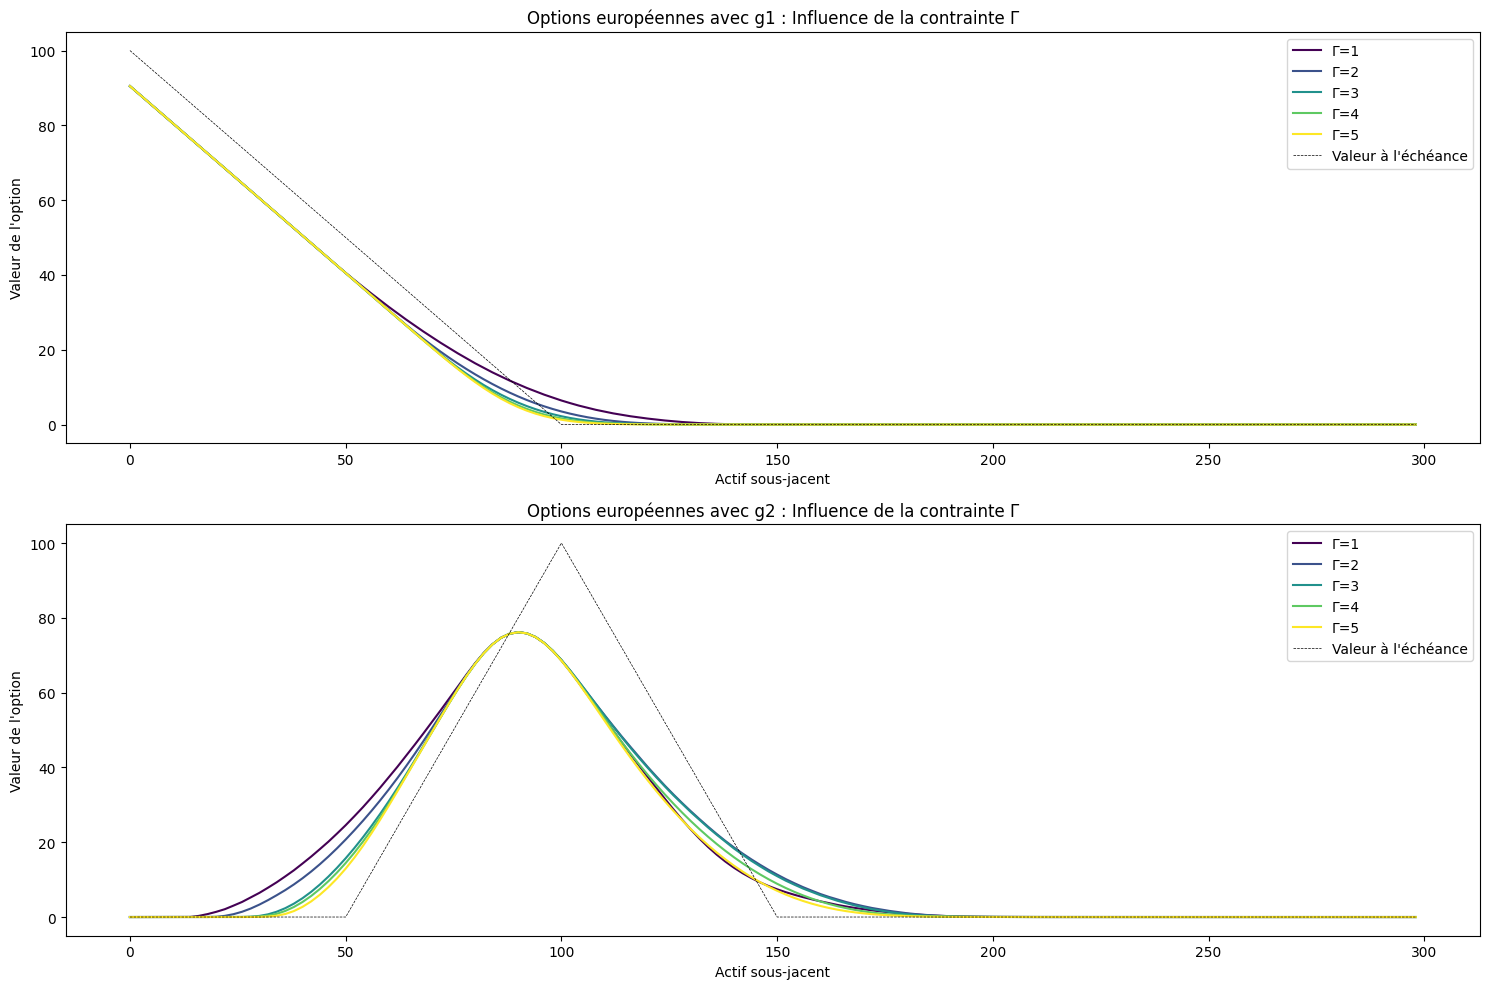

In [50]:
gammas = [1, 2, 3, 4, 5]
colors = plt.cm.viridis(np.linspace(0, 1, len(gammas)))

fig, axs = plt.subplots(2, 1, figsize=(15, 10))

for gamma, color in zip(gammas, colors):
    x, U0_g, Uj_g_constraint, _ = solve_cn(g, True, Gamma=gamma)
    axs[0].plot(x, Uj_g_constraint, label=f"Γ={gamma}", color=color)
axs[0].plot(x, U0_g, label="Valeur à l'échéance", color="black", linestyle="dashed", linewidth=0.5)
axs[0].set_xlabel("Actif sous-jacent")
axs[0].set_ylabel("Valeur de l'option")
axs[0].set_title("Options européennes avec g1 : Influence de la contrainte Γ")
axs[0].legend()

for gamma, color in zip(gammas, colors):
    x, U0_g2, Uj_g2_constraint, _ = solve_cn(g2, True, Gamma=gamma)
    axs[1].plot(x, Uj_g2_constraint, label=f"Γ={gamma}", color=color)
axs[1].plot(x, U0_g2, label="Valeur à l'échéance", color="black", linestyle="dashed", linewidth=0.5)
axs[1].set_xlabel("Actif sous-jacent")
axs[1].set_ylabel("Valeur de l'option")
axs[1].set_title("Options européennes avec g2 : Influence de la contrainte Γ")
axs[1].legend()

plt.tight_layout()
plt.show()

    

## 4. Coûts de transaction et modèle de Leland,1985

On ajoute un cout de transaction suivant le modèle de Leland,1985. On définit la fonction ```solve_cn_leland``` qui permet de résoudre le problème en incorporant le cout de transaction. C'est simplement une adaptation de la fonction ```solve_cn``` 

In [51]:
def mat_A_with_transaction_cost(sigma, r, x, Le, Uj):
    N = x.size
    h = x[1] - x[0]

    dUj_ds = np.zeros_like(Uj)
    dUj_ds[1:-1] = (Uj[2:] - Uj[:-2]) / (2 * h)
    dUj_ds[0] = (Uj[1] - Uj[0]) / h 
    dUj_ds[-1] = (Uj[-1] - Uj[-2]) / h

    abs_dUj_ds = np.abs(dUj_ds)

    A1 = (
        -1
        / (2.0 * h * h)
        * np.diag(np.power(sigma * x, 2)).dot(
            np.eye(N, k=-1) - 2.0 * np.eye(N) + np.eye(N, k=1)
        )
    )
    A1 += Le * np.diag(abs_dUj_ds)

    A2 = -1 / (2 * h) * np.diag(r * x).dot(-np.eye(N, k=-1) + np.eye(N, k=1))

    A3 = r * np.eye(N)

    return A1 + A2 + A3

In [52]:
def solve_cn_with_transaction_cost(
    payoff_func, with_constraint=True, Gamma=Gamma, Le=5
):
    x = np.linspace(0, bar_x, N, endpoint=False)
    h = x[1] - x[0]
    k = T / J

    U0 = payoff_func(x, K)
    Uj = U0.copy()

    solutions = []

    for j in range(J):
        A = mat_A_with_transaction_cost(sigma, r, x, Le, Uj)
        B1 = np.eye(N) + k / 2.0 * A
        B2 = np.eye(N) - k / 2.0 * A

        Uj_temp = np.linalg.solve(B1, B2.dot(Uj))
        if with_constraint:
            Uj = project_gamma_constraint(Uj_temp, x, h, Gamma)
        else:
            Uj = Uj_temp

        if (j + 1) % 10 == 0:
            solutions.append(Uj.copy())

    return x, U0, Uj, solutions

In [53]:
leland = 1

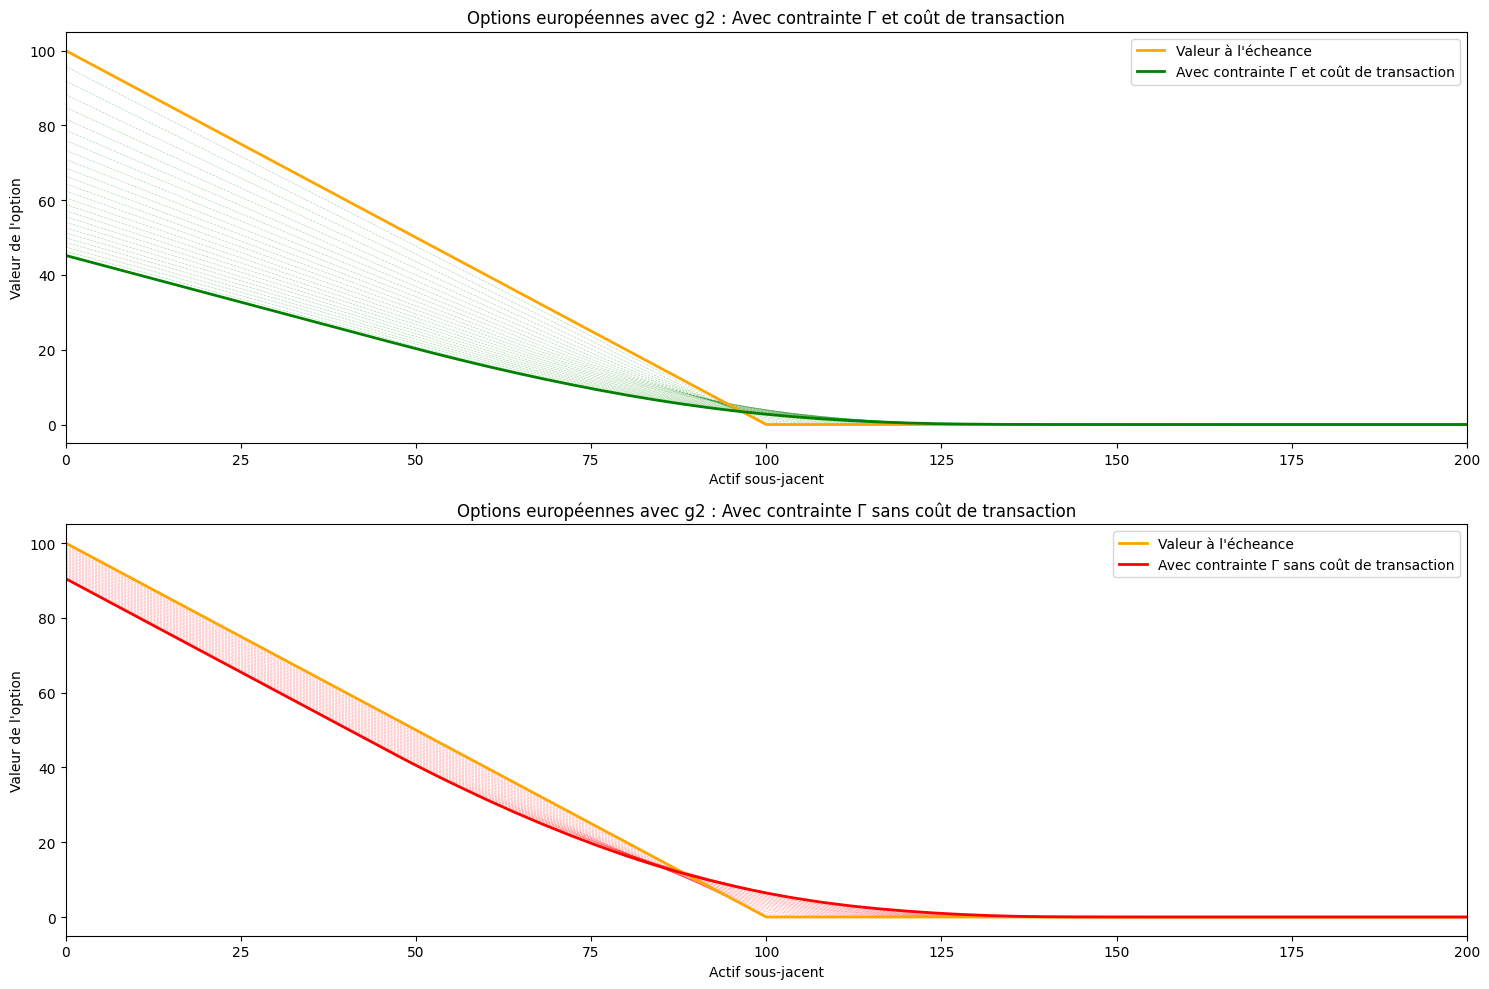

In [54]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

x, U0_g_le, Uj_g_constraint_le, solutions_g_constraint_le = (
    solve_cn_with_transaction_cost(g, True, Le=leland)
)
_, U0_g, Uj_g_constraint, solutions_g_constraint = solve_cn(g, True)

for sol in solutions_g_constraint_le:
    axs[0].plot(x, sol, color="green", linestyle="dashed", linewidth=0.5, alpha=0.3)
for sol in solutions_g_constraint:
    axs[1].plot(x, sol, color="red", linestyle="dashed", linewidth=0.5, alpha=0.3)

axs[0].plot(
    x,
    U0_g_le,
    color="orange",
    linestyle="solid",
    linewidth=2,
    label="Valeur à l'écheance"
)
axs[0].plot(
    x,
    Uj_g_constraint_le,
    color="green",
    linestyle="solid",
    linewidth=2,
    label="Avec contrainte Γ et coût de transaction",
)

axs[1].plot(    
    x,
    U0_g,
    color="orange",
    linestyle="solid",
    linewidth=2,
    label="Valeur à l'écheance"
)

axs[1].plot(
    x,
    Uj_g_constraint,
    color="red",
    linestyle="solid",
    linewidth=2,
    label="Avec contrainte Γ sans coût de transaction",
)

axs[0].set_xlabel("Actif sous-jacent")
axs[0].set_ylabel("Valeur de l'option")
axs[0].set_xlim((0.0, 200))
axs[0].set_title("Options européennes avec g2 : Avec contrainte Γ et coût de transaction")
axs[0].legend()

axs[1].set_xlabel("Actif sous-jacent")
axs[1].set_ylabel("Valeur de l'option")
axs[1].set_xlim((0.0, 200))
axs[1].set_title("Options européennes avec g2 : Avec contrainte Γ sans coût de transaction")
axs[1].legend()


plt.tight_layout()
plt.show()

### Comparaison pour différents Nombres de Leland
***

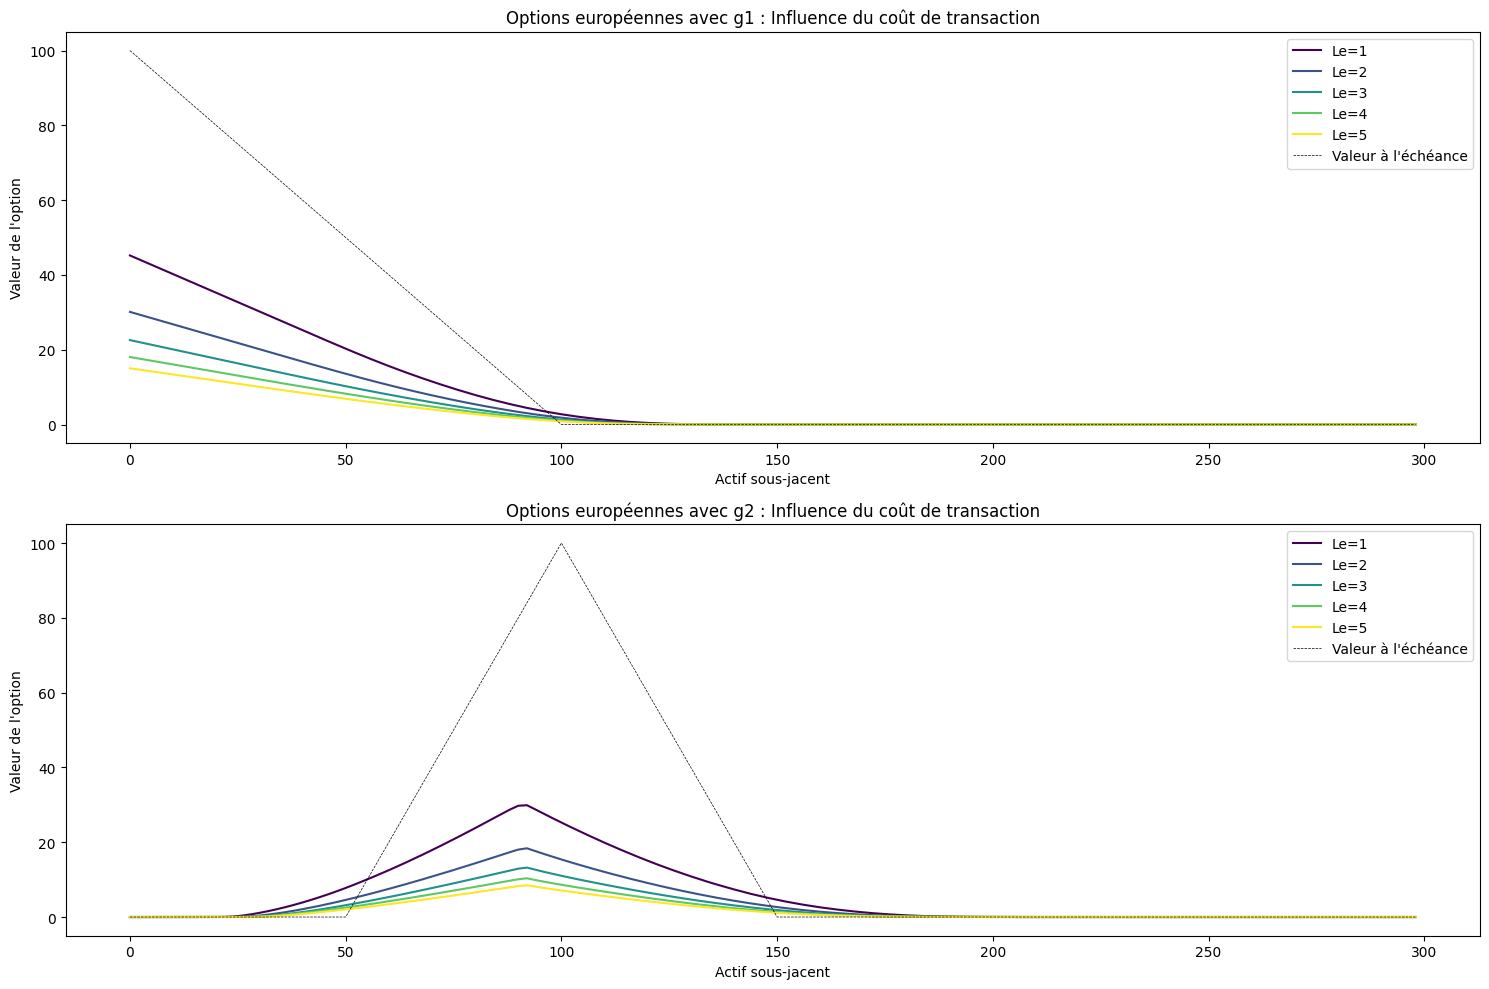

In [55]:
lelands = [1, 2, 3, 4, 5]
colors = plt.cm.viridis(np.linspace(0, 1, len(lelands)))

fig, axs = plt.subplots(2, 1, figsize=(15, 10))

for le, color in zip(lelands, colors):
    x, U0_g_le, Uj_g_constraint_le, _ = solve_cn_with_transaction_cost(
        g, True, Le=le
    )
    axs[0].plot(x, Uj_g_constraint_le, label=f"Le={le}", color=color)
axs[0].plot(
    x,
    U0_g_le,
    label="Valeur à l'échéance",
    color="black",
    linestyle="dashed",
    linewidth=0.5,
)
axs[0].set_xlabel("Actif sous-jacent")
axs[0].set_ylabel("Valeur de l'option")
axs[0].set_title("Options européennes avec g1 : Influence du coût de transaction")
axs[0].legend()

for le, color in zip(lelands, colors):
    x, U0_g2_le, Uj_g2_constraint_le, _ = solve_cn_with_transaction_cost(
        g2, True, Le=le
    )
    axs[1].plot(x, Uj_g2_constraint_le, label=f"Le={le}", color=color)
axs[1].plot(
    x,
    U0_g2_le,
    label="Valeur à l'échéance",
    color="black",
    linestyle="dashed",
    linewidth=0.5,
)
axs[1].set_xlabel("Actif sous-jacent")
axs[1].set_ylabel("Valeur de l'option")
axs[1].set_title("Options européennes avec g2 : Influence du coût de transaction")
axs[1].legend()

plt.tight_layout()
plt.show()